Track the model's `performance` using `wandb` on adding dropout.

In [1]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: raghvender. Use `wandb login --relogin` to force relogin


True

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1. Download dataset and prepare `DataLoaders`

In [4]:
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat",
               "deer", "dog", "frog", "horse", "ship", "truck")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2. Visualize Data

In [5]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        img = image_batch[i] / 2 + 0.5     # unnormalize
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(CLASS_NAMES[label_batch[i]])
        plt.axis("off")

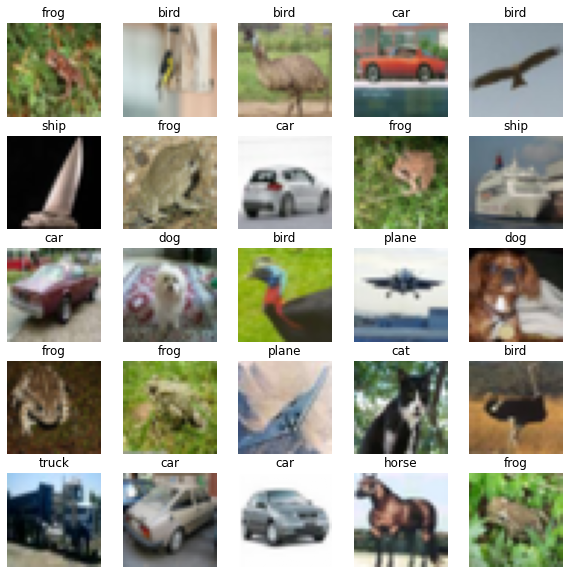

In [6]:
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

### 3. Training Function

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, steps_per_epoch=20):
    model.train()

    train_loss = 0
    train_total = 0
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader, start=0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # Forward Pass
        output = model(data) 
        
        loss = criterion(output, target)
        train_loss += loss.item()

        scores, predictions = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += int(sum(predictions == target))

        optimizer.zero_grad()
        # Backward Pass
        loss.backward()

        optimizer.step() # Update weights
    
    acc = round((train_correct / train_total) * 100, 2)
    print("Epoch [{}], Loss: {}, Accuracy: {}".format(epoch, train_loss/train_total, acc), end="")
    wandb.log({"Train Loss": train_loss/train_total, "Train Accuracy": acc, "Epoch": epoch})

### 4. Test Function

In [8]:
def test(model, device, test_loader, criterion, classes):
    model.eval()

    test_loss = 0
    test_total = 0
    test_correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            # Load the input features and labels from the test dataset
            data, target = data.to(device), target.to(device)

            output = model(data)
            
            # Compute the loss sum up batch loss
            test_loss += criterion(output, target).item()
            
            scores, predictions = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += int(sum(predictions == target))

    acc = round((test_correct / test_total) * 100, 2)
    print(" Test_loss: {}, Test_accuracy: {}".format(test_loss/test_total, acc))
    wandb.log({"Test Loss": test_loss/test_total, "Test Accuracy": acc})

### 5. Model

In [15]:
class Model(nn.Module):
    def __init__(self, input_shape=(3, 32, 32)):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        self.pool = nn.MaxPool2d(2,2)

        n_size = self._get_conv_output(input_shape)
        
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Initialize Model, Loss and Optimizer

In [16]:
model = Model().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### 6. Train

In [17]:
wandb.init(project='Effect-of-Dropout-WandbExample')
wandb.watch(model, log='all')

for epoch in range(10):
    train(model, device, trainloader, optimizer, criterion, epoch)
    test(model, device, testloader, criterion, CLASS_NAMES)

print('****************** Finished Training *****************')
wandb.finish()

Epoch [0], Loss: 0.04441666703224182, Accuracy: 48.1 Test_loss: 0.036059745329618455, Test_accuracy: 58.4
Epoch [1], Loss: 0.031902389776706695, Accuracy: 63.77 Test_loss: 0.03016975330412388, Test_accuracy: 66.58
Epoch [2], Loss: 0.0266381117194891, Accuracy: 70.23 Test_loss: 0.029283101454377174, Test_accuracy: 67.1
Epoch [3], Loss: 0.023035015452504158, Accuracy: 74.18 Test_loss: 0.02679672584235668, Test_accuracy: 70.62
Epoch [4], Loss: 0.02016263790369034, Accuracy: 77.34 Test_loss: 0.025116409602761267, Test_accuracy: 72.68
Epoch [5], Loss: 0.017623583660647275, Accuracy: 80.2 Test_loss: 0.026589948070049284, Test_accuracy: 71.76
Epoch [6], Loss: 0.015600979350805283, Accuracy: 82.47 Test_loss: 0.02624937923550606, Test_accuracy: 72.01
Epoch [7], Loss: 0.013487814645171166, Accuracy: 84.67 Test_loss: 0.027353462183475494, Test_accuracy: 73.42
Epoch [8], Loss: 0.011530325270071626, Accuracy: 86.82 Test_loss: 0.02962118860781193, Test_accuracy: 73.0
Epoch [9], Loss: 0.0097994402009

Epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,▁▅▅▇█▇▇███
Test Loss,█▄▄▂▁▂▂▂▄▅
Train Accuracy,▁▄▅▅▆▇▇▇██
Train Loss,█▅▄▄▃▃▂▂▁▁
Epoch,9
Test Accuracy,72.76
Test Loss,0.03214
Train Accuracy,88.78
Train Loss,0.0098
